# Text Classification for DRF Service Descriptions
The object of this project is to build a NLP model to categorize text descriptions of [Data & Reasoning Fabric](https://drf.nasa.gov/) services. For now, we will be using an open-source [e-commerce dataset](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification) as a placeholder for DRF service text descriptions. This dataset consists of two columns, description and label. Each description can be any of the following labels: `Household`, `Electronics`, `Books`, or `Clothing & Accessories`.

To do this, we will perform cross-validation on the following machine learning classifiers: `LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier`, `svm.SVC`, `SGDClassifier`, and `RidgeClassifier`. We will analyze these classifiers using BERT, tuning hyperparameters to best fit the dataset.

In [23]:
# Importing libraries
import numpy as np
import pandas as pd
import spacy
import re
import string
import nltk
import copy
import gensim

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer

from scipy.sparse import csr_matrix, hstack

In [3]:
# Load the dataset
dataset = "./ecommerceDataset.csv"
data = pd.read_csv(dataset, names=["label", "description"])
data = data[["description", "label"]]

# Clean the data - drop duplicates and missing values
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

data

,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,Electronics
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,Electronics
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",Electronics
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics


Min Length : 4
Max Length : 50403
Mean Length : 699.9949284224157
Median length : 473.0


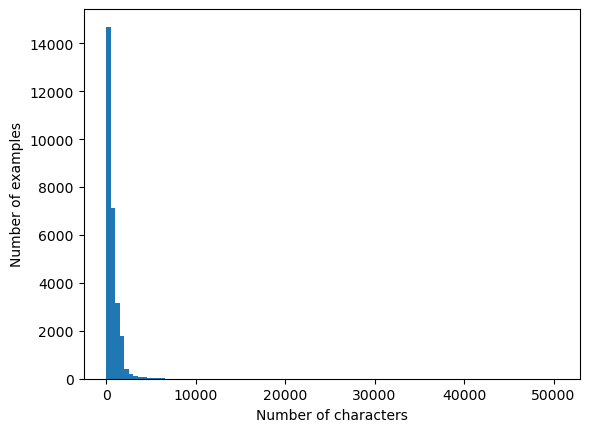

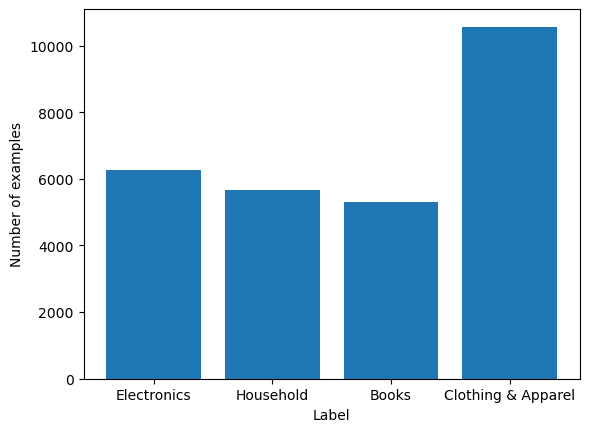

In [5]:
# Initial data analysis
min_length=data["description"].str.len().min()
max_length=data["description"].str.len().max()
average_length=data["description"].str.len().mean()
median_length=data["description"].str.len().median()
print("Min Length :", min_length)
print("Max Length :", max_length)
print("Mean Length :", average_length)
print("Median length :", median_length)

counts, bins = np.histogram(data["description"].str.len(), 100)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel("Number of characters")
plt.ylabel("Number of examples")
plt.show()

distribution = data.groupby("label").count()
plt.bar(["Electronics", "Household", "Books", "Clothing & Apparel"], distribution["description"])
plt.xlabel("Label")
plt.ylabel("Number of examples")
plt.show()

In [4]:
# Text normalization utils
regexp = RegexpTokenizer("[\w']+")

acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')
acronyms_list = list(acronyms_dict.keys())

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
allstops = stops + addstops + alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])

def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    return text_spacy

def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

In [5]:
# Text normalization
def text_normalizer(text):
    text = text.lower()
    text = text.strip()
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    text = text_lemmatizer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    return text

X = data["description"].apply(text_normalizer)
y = data["label"]
data

,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,Electronics
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,Electronics
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",Electronics
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics


In [20]:
# Classifiers
n_neighbors = int(np.floor(np.sqrt(data.shape[0])))

names = [
    "Logistic Regression",
    f"KNN with {n_neighbors} neighbors",
    "Decision Tree Classifier",
    "Linear SVM",
    "SGD Classifier",
    "Ridge Classifier"
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear', max_iter = 1000),
    SGDClassifier(max_iter = 1000),
    RidgeClassifier(max_iter = 1000)
]

In [13]:
def error(clf, X, y, ntrials=100, test_size=0.2) :
    train_error = 0
    test_error = 0
    
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)

    for train_index, test_index in sss.split(X, y):
      clf.fit(X[train_index], y[train_index])
      y_pred_train = clf.predict(X[train_index])
      y_pred_test = clf.predict(X[test_index])
      train_error += 1 - accuracy_score(y[train_index], y_pred_train, normalize=True)
      test_error += 1 - accuracy_score(y[test_index], y_pred_test, normalize=True)

    train_error /= ntrials
    test_error /= ntrials

    return train_error, test_error

In [14]:
# Calculate the score for each classifier
def score(X, y, folds=5, models=models, names=names):
    for i in range(len(models)):
        e = error(models[i], X, y, ntrials=folds)
        train_score = 1 - e[0]
        test_score = 1 - e[1]
#         scores = cross_validate(models[i], X, y, cv=folds, return_train_score=True)
#         train_score = scores["train_score"].mean()
#         test_score = scores["test_score"].mean()
        print(names[i])
        print(f"\t Train accuracy: {train_score}")
        print(f"\t Test accuracy: {test_score}")

In [25]:
# TF-IDF analysis
TfidfVec = TfidfVectorizer()
X_tfidf = TfidfVec.fit_transform(X)
score(X_tfidf, y) 

In [14]:
# TF-IDF tuning hyperparameters for best classifier
rc = RidgeClassifier()
rc_params = {
    "alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
best_score = 0
best_model = rc
best_params = ParameterGrid(rc_params)[0]
for p in ParameterGrid(rc_params):
    rc.set_params(**p)
    e = error(rc, X_tfidf, y)
    train_score = 1 - e[0]
    test_score = 1 - e[1]
    print(f"Parameters: {p}")
    print(f"\t Train accuracy: {train_score}")
    print(f"\t Test accuracy: {test_score}")
    
    if test_score > best_score:
        best_score = test_score
        best_model = rc
        best_params = p
        
print(f"\nBest model: {best_model} with {best_params} | score: {best_score}")

Parameters: {'alpha': 0.1}
	 Train accuracy: 0.9969587698394856
	 Test accuracy: 0.9471749685308397
Parameters: {'alpha': 0.2}
	 Train accuracy: 0.9949768445663414
	 Test accuracy: 0.9502049991008812
Parameters: {'alpha': 0.3}
	 Train accuracy: 0.9932480553931927
	 Test accuracy: 0.9513900377629922
Parameters: {'alpha': 0.4}
	 Train accuracy: 0.991563778607077
	 Test accuracy: 0.9517245099802194
Parameters: {'alpha': 0.5}
	 Train accuracy: 0.9899154714266445
	 Test accuracy: 0.9519762632620032
Parameters: {'alpha': 0.6}
	 Train accuracy: 0.9884497099950542
	 Test accuracy: 0.9521866570760654
Parameters: {'alpha': 0.7}
	 Train accuracy: 0.9871498583696776
	 Test accuracy: 0.9523323143319546
Parameters: {'alpha': 0.8}
	 Train accuracy: 0.9858909221707657
	 Test accuracy: 0.9523035425283222
Parameters: {'alpha': 0.9}
	 Train accuracy: 0.9846845915201654
	 Test accuracy: 0.9522459989210573
Parameters: {'alpha': 1.0}
	 Train accuracy: 0.9834175621599748
	 Test accuracy: 0.9521434993706168



In [7]:
# word2vec analysis
word2vec_path = './GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [9]:
# word2vec helper functions
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

In [18]:
X_word2vec = get_word2vec_embeddings(word2vec, X)
X_word2vec_csr = csr_matrix(X_word2vec)
score(X_word2vec_csr, y)

Logistic Regression
	 Train accuracy: 0.5094555100939706
	 Test accuracy: 0.5062758496673261
KNN with 166 neighbors
	 Train accuracy: 0.5400386673261094
	 Test accuracy: 0.5313432835820896
Decision Tree Classifier
	 Train accuracy: 0.9998291443730049
	 Test accuracy: 0.48814961337888874
Linear SVM
	 Train accuracy: 0.48289195629692905
	 Test accuracy: 0.4772882575076426
SGD Classifier
	 Train accuracy: 0.5097432669394363
	 Test accuracy: 0.5065276029491099
Ridge Classifier
	 Train accuracy: 0.5057416483071805
	 Test accuracy: 0.503722352094947


In [27]:
best_model_tfidf = RidgeClassifier(alpha=0.7)
best_model_tfidf.fit(X_tfidf, y)

best_model_word2vec = KNeighborsClassifier(n_neighbors=166, n_jobs = -1)
best_model_word2vec.fit(X_word2vec, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=166)

In [35]:
# description = "Table Lamp with Pull Chain: The USB Bedside Table Lamp comes with a stylish pull chain to control the lamp, you can easy to turn on or turn off the light by pulling the chain, even in the darkness."
description = "A workwear staple, this men's pocket t-shirt is equal parts durable and comfortable. It has an original fit, Carhartt's roomiest cut. The heavyweight fabric only gets softer with time."
# description = "NEW YORK TIMES BESTSELLER • The epic tale of a woman who breathes a fantastical empire into existence, only to be consumed by it over the centuries—from the transcendent imagination of Booker Prize–winning, internationally bestselling author Salman Rushdie"
# description = "Dominate on a different scale with the Razer Huntsman Mini TKL — a 60% gaming keyboard with cutting-edge Razer Clicky Optical Switches. Highly portable and ideal for streamlined setups, it’s time to experience lightning-fast actuation in our most compact form factor yet."

example = [[description]]
df = pd.DataFrame(example, columns=["description"])
X_example = df["description"].apply(text_normalizer)

X_example_tfidf = TfidfVec.fit_transform(X_example)
X_example_word2vec = get_word2vec_embeddings(word2vec, X_example)

zeros = np.zeros((X_tfidf.shape[1] - X_example_tfidf.shape[1]), dtype=int)
row = zeros
col = []
for i in range(X_tfidf.shape[1] - X_example_tfidf.shape[1]):
    col.append(i)
col = np.array(col)
padding = csr_matrix((zeros, (row, col)))
X_example_padded = hstack((X_example_tfidf, padding))

print(f"TFIDF + RidgeClassifier: {best_model_tfidf.predict(X_example_padded)[0]}")

print(f"word2vec + KNN 166: {best_model_word2vec.predict(X_example_word2vec)[0]}")

TFIDF + RidgeClassifier: Books
word2vec + KNN 166: Clothing & Accessories


### References
https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/

https://towardsdatascience.com/model-selection-in-text-classification-ac13eedf6146 

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

https://www.kaggle.com/code/sugataghosh/e-commerce-text-classification-tf-idf-word2vec#Word2Vec-Model

https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d